# Определение возраста покупателей

# Исследовательский анализ данных

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

# План работы

- Провеcти исследовательский анализ набора фотографий.
- Подготовить данные к обучению.
- Обучить нейронную сеть и рассчитайте её качество.

# Описание данных

Данные взяты с сайта ChaLearn Looking at People. Они находятся в папке `/datasets/faces/`. 

В распоряжении одна папка со всеми изображениями (/final_files) и CSV-файл `labels.csv` с двумя колонками: `file_name` и `real_age`.

**Импортируем необходимые библиотеки вначале документа (pandas, numpy и другие).**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator 

**Считаем данные из csv-файла и сохраним в переменную `data`.**

In [2]:
data = pd.read_csv('/datasets/faces/labels.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


**Размер выборки составляет 7591 файл, в котором каждой фотографии присвоен реальный возраст человека.**

**Выведем первые 5 строк датафрейма `data` на экран.**

In [3]:
data.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


**Построим график (гистограмму распределения возраста в файле)**

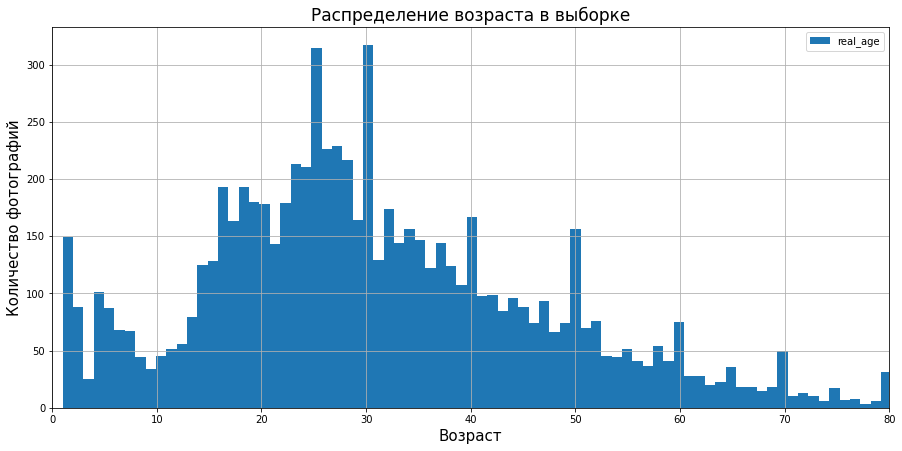

In [4]:
data.plot(kind='hist', y='real_age', bins=100, grid=True, figsize=(15,7));
plt.xlim(0, 80)

plt.title('Распределение возраста в выборке', fontsize=17)
plt.xlabel('Возраст', fontsize=15) 
plt.ylabel('Количество фотографий', fontsize=15)
plt.show()

Пики в районе "юбилейных" лет, они тут могут быть связаны с тем, что настоящий возраст был неизвестен тому, кто размечал датасет, и он попросту округлял его.

Построим ящик с усами:

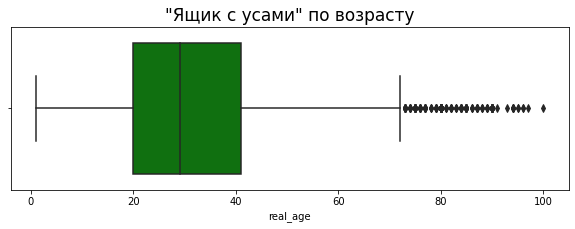

In [5]:
plt.figure(figsize=(10,3))
sns.boxplot(x=data['real_age'], color='g')
plt.title(label='"Ящик с усами" по возрасту', fontdict={'fontsize': 17})
plt.show()

In [6]:
data['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

Если посмотреть на гистограмму, то она скошена влево - то есть в выборке чаще встречаются фотографии людей младше 30 лет. 

Медиана у нас 29 лет. 1-ый квантиль 20 лет, 3-ий квантиь 41 год.
Также в выборке присутствуют фотографии детей младше 7 лет. Что для данной задачи не совсем приемлемо, так как они не будут совершать покупки. 

**Чтобы загрузить фото, создадим загрузчик ImageDataGenerator**

In [7]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255) 

In [8]:
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


После применения метода `datagen.flow_from_directory(...)`, получим объект, у которого пары «картинки — метки»

In [9]:
features, target = train_gen_flow.next()

In [10]:
print(features.shape) 

(32, 224, 224, 3)


Напечатаем первые 16 фото.

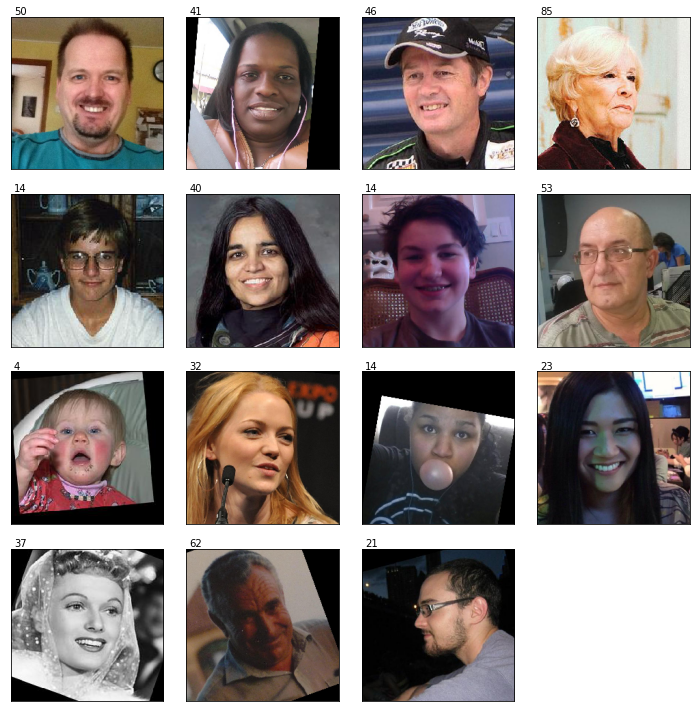

In [11]:
fig = plt.figure(figsize=(10,10))
for i in range(15):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.text(4, -4, target[i])
    # для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

**Вывод:** Фото имеют разный поворот, фон, ракурс, качество. Также на фото могут быть посторонние предметы (микрофон, очки, жвачка), что усложняет определение возраста.

Общая ориентация фотографий примерно одинакова - в некоторых фото их уже повернули за нас, чтобы выровнять положение лица, значит нам их не обязательно поворачивать, а начальный размер изображений отличается, в силу того, что визуально заметно различное качество фото, где-то есть черные рамки (они не несут полезной информации). В итоге, размер изображений мы приведем к единому перед обучением модели.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
import pandas as pd
 
def load_train(path):
    labels = pd.read_csv(path+'labels.csv')
    train_datagen = ImageDataGenerator(rescale=1./255,
                                       horizontal_flip=True,
                                       width_shift_range=.2, 
                                       height_shift_range=.2,
                                       validation_split=0.25)
 
    train_datagen_flow = train_datagen.flow_from_dataframe(
      dataframe=labels,
      directory=path + 'final_files/',
      x_col='file_name',
      y_col='real_age',
      target_size=(224, 224),
      batch_size=32,
      class_mode='raw',
      subset='training',
      seed=12345)
    return train_datagen_flow
 
def load_test(path):
    labels = pd.read_csv(path +'labels.csv')
    test_datagen = ImageDataGenerator(rescale=1/255.,validation_split=0.25,)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe= labels,
        directory= path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
    return test_datagen_flow
 
def create_model(input_shape):
    optimizer = Adam(lr=0.0001)
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)
 
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(10, activation='relu'))
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
 
    return model
 
 
def train_model(model, train_data, test_data, batch_size=None, epochs=19,
               steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
 
    return model

```

```

Train for 178 steps, validate for 60 steps
Epoch 1/19
2023-07-26 15:15:57.580466: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-07-26 15:15:58.809913: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 126s - loss: 380.9404 - mae: 14.6139 - val_loss: 973.8189 - val_mae: 26.4489
Epoch 2/19
178/178 - 95s - loss: 101.8702 - mae: 7.5523 - val_loss: 929.9580 - val_mae: 25.6774
Epoch 3/19
178/178 - 96s - loss: 76.7787 - mae: 6.6393 - val_loss: 429.5017 - val_mae: 15.7926
Epoch 4/19
178/178 - 98s - loss: 62.9421 - mae: 6.0204 - val_loss: 113.4434 - val_mae: 8.2708
Epoch 5/19
178/178 - 97s - loss: 52.0102 - mae: 5.5340 - val_loss: 82.5379 - val_mae: 6.9654
Epoch 6/19
178/178 - 95s - loss: 44.7810 - mae: 5.1340 - val_loss: 74.5265 - val_mae: 6.5794
Epoch 7/19
178/178 - 97s - loss: 40.2216 - mae: 4.8659 - val_loss: 70.5527 - val_mae: 6.2234
Epoch 8/19
178/178 - 99s - loss: 33.5544 - mae: 4.4689 - val_loss: 70.9602 - val_mae: 6.3753
Epoch 9/19
178/178 - 96s - loss: 31.8118 - mae: 4.3445 - val_loss: 65.7525 - val_mae: 6.1815
Epoch 10/19
178/178 - 94s - loss: 27.8956 - mae: 4.0880 - val_loss: 64.5973 - val_mae: 6.0220
Epoch 11/19
178/178 - 91s - loss: 25.1119 - mae: 3.8699 - val_loss: 71.4011 - val_mae: 6.2181
Epoch 12/19
178/178 - 96s - loss: 23.5623 - mae: 3.7461 - val_loss: 67.2751 - val_mae: 6.0356
Epoch 13/19
178/178 - 94s - loss: 21.3587 - mae: 3.5696 - val_loss: 65.4534 - val_mae: 6.0456
Epoch 14/19
178/178 - 95s - loss: 21.2074 - mae: 3.5517 - val_loss: 66.8331 - val_mae: 5.9834
Epoch 15/19
178/178 - 95s - loss: 19.1678 - mae: 3.3849 - val_loss: 85.2526 - val_mae: 6.7605
Epoch 16/19
178/178 - 92s - loss: 18.7548 - mae: 3.3279 - val_loss: 89.1773 - val_mae: 7.0626
Epoch 17/19
178/178 - 91s - loss: 17.1545 - mae: 3.1937 - val_loss: 65.7904 - val_mae: 5.9633
Epoch 18/19
178/178 - 91s - loss: 15.6659 - mae: 3.0520 - val_loss: 65.3255 - val_mae: 5.9244
Epoch 19/19
178/178 - 91s - loss: 15.0212 - mae: 3.0181 - val_loss: 71.9595 - val_mae: 6.3340

```

**Вывод:** Получили на тестовой выборке метрику качества МАЕ - 5.89, что соответсвует цели (mae < 8). 

## Анализ обученной модели

**Анализ выборки:** Выборка скошена в левую сторону - то есть чаще встречаются люди с возрастом 20-40. Медиана данной выборки 29 лет. Также, фото имеют различное качество и посторонние предметы - на лицах(очки, наушники, микрофон), которые могут усложнять определение возраста.

**Анализ модели:** Обученная свёрточная нейронная сеть ResNet50 показала метрику качества 5.89, что соответствует целям исследования.
Модель может ошибаться в предсказании на лет. Что позволяет внедрить ее для:
 - Анализа покупок и предложения товаров, которые могут заинтересовать покупателей определенной возрастной группы;
 - Контроля добросовестности кассиров при продаже алкоголя.

Для улучшения качества метрики `mae` - уменьшили 'скорость обучения' - гиперпараметр в алгоритме `Adam`.

А также увеличено количество эпох до 19. 

Модель работает на архитектуре ResNet50, адаптированной для данной задачи. 
